In [13]:
import numpy as np
from scipy import integrate
import torch

import matplotlib
import matplotlib.pyplot as plt

p_total:  0.18140542135542154


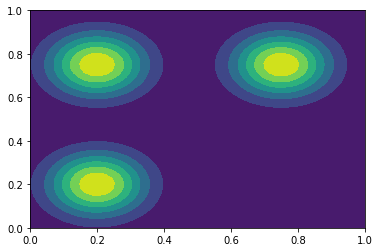

In [2]:
def normalize_mu(p):
    p_total, _ = integrate.nquad(lambda *x: p(np.array(x)), [[0, 1], [0, 1]])
    print("p_total: ", p_total)
    return lambda x: p(x)/p_total
def unnorm_p1(x): 
    return np.exp(-50.5 * np.sum((x[:2] - 0.2)**2)) \
                + np.exp(-50.5 * np.sum((x[:2] - 0.75)**2)) \
                + np.exp(-50.5 * np.sum((x[:2] - np.array([0.2, 0.75]))**2))
p1 = normalize_mu(unnorm_p1)

# Grid and Display
X,Y = np.meshgrid(*[np.linspace(0,1)]*2)
_s = np.stack([X.ravel(), Y.ravel()]).T


plt.contourf(X, Y, np.array(list(map(p1, _s))).reshape(X.shape))

In [3]:
from fourier_functions import Fourier_Functions

mu = p1
ff = Fourier_Functions(mu, (1,1), 3, printProgress=True)
# 4 min

Fourier Functions (mu, U_shape= (1, 1) , K= 3 ...
Computing constants (new_k, h_k, lambda_k)...
Computing torch fourier functions (f_k, df_k)...
Computing mu fourier coefficients (mu_k)...
Computing casadi fourier function (casadi_f_k)...
Aggregating all constants and functions into one dict...
{(0, 0): {'new_k': array([0., 0.]), 'h_k': 1.0, 'lambda_k': 1.0, 'f_k': <function torch_fourier_k.<locals>.<lambda> at 0x7fc50b65dc10>, 'df_k': <function torch_dfourier_k.<locals>.<lambda> at 0x7fc50b65dd30>, 'mu_k': 1.0, 'casadi_f_k': <function casadi_fourier_k.<locals>.<lambda> at 0x7fc50a592550>}, (0, 1): {'new_k': array([0.        , 3.14159265]), 'h_k': 0.7071067811865476, 'lambda_k': 0.027904830742777952, 'f_k': <function torch_fourier_k.<locals>.<lambda> at 0x7fc50b65ddc0>, 'df_k': <function torch_dfourier_k.<locals>.<lambda> at 0x7fc50b65dee0>, 'mu_k': -0.28332763192937704, 'casadi_f_k': <function casadi_fourier_k.<locals>.<lambda> at 0x7fc50a5925e0>}, (0, 2): {'new_k': array([0.        ,

(2500, 2)
(2500, 2)
(50, 50)
[50 50  2]


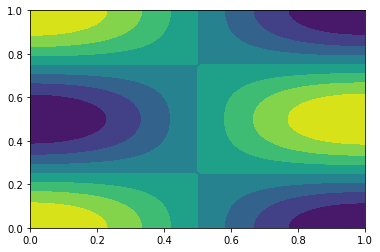

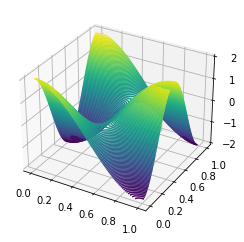

In [35]:
print(_s.shape)
ans = np.array(_ff['df_k'](torch.tensor(_s)))
print(ans.shape)
print(X.shape)
print(np.array(ans.reshape((len(X), len(Y), -1)).shape))

_ff = ff[(1,2)]
f_k = np.array(list(map(_ff['f_k'], _s))).reshape(X.shape)
plt.contourf(X, Y, f_k)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, f_k, 100) #, 50, cmap='binary'

{'new_k': array([0., 0.]), 'h_k': 1.0, 'lambda_k': 1.0, 'f_k': <function torch_fourier_k.<locals>.<lambda> at 0x7fc50b65dc10>, 'df_k': <function torch_dfourier_k.<locals>.<lambda> at 0x7fc50b65dd30>, 'mu_k': 1.0, 'casadi_f_k': <function casadi_fourier_k.<locals>.<lambda> at 0x7fc50a592550>}
f_k
df_k


<ipython-input-15-9a33774468f1>:7: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  plt.contourf(X, Y, np.array(list(map(lambda *x: _ff['df_k'](torch.tensor(x)), _s))).reshape(X.shape))
<ipython-input-15-9a33774468f1>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.contourf(X, Y, np.array(list(map(lambda *x: _ff['df_k'](torch.tensor(x)), _s))).reshape(X.shape))


ValueError: only one element tensors can be converted to Python scalars

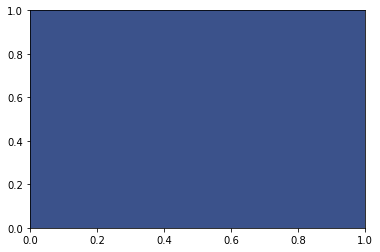

In [15]:
for k in ff:
    _ff = ff[k]
    print(_ff)
    print("f_k")
    f_k = np.array(list(map(_ff['f_k'], _s))).reshape(X.shape)
    plt.contourf(X, Y, f_k)

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.contour3D(X, Y, f_k, 50, cmap='binary')

    print("df_k")
    plt.contourf(X, Y, np.array(_ff['df_k'](torch.tensor(_s)).reshape(X.shape, Y.shape, -1))


In [10]:
a = {'a':1, 'b':2}
for aa in a:
    print(aa)

a
b
